In [1]:
import sys
import itertools
import json
from pprint import pprint
from typing import List

import clip  # type: ignore
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr, pearsonr

from datasets import AttributeDataset, ImageDataset, TextDataset, create_dataloader
from models import Linear
from trainer import run_one_epoch
from utils import computing_subgroup_metrics, subgrouping
from matplotlib import pyplot as plt
from utils import openai_imagenet_template, openai_imagenet_classes
from collections import defaultdict


CLIP_MODEL = "ViT-B/32"
LINEAR_MODEL = "dspites_linear_model_2class.pt"
N_CLASS = 2
clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float()
model = Linear(clip_model.visual.output_dim, N_CLASS).cuda()
state_dict = torch.load(LINEAR_MODEL)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Slice Analysis

## [Preparation] Ground-truth image dataset and text cross-product performance

In [2]:
image_data = [
    json.loads(line)
    for line in open("data/TriangleSquare/processed_attribute_dataset/attributes.jsonl")
]
train_idxs, val_idxs = json.load(open("mmdebug/src/train_val_idxs_2class.json"))
image_data = [x for i, x in enumerate(image_data) if i in val_idxs]

for item in image_data:
    item["label"] = item["attributes"]["label"]
    if item["attributes"]["scale"] < 0.9:
        item["attributes"]["concrete_scale"] = 0
    elif item["attributes"]["scale"] > 1.1:
        item["attributes"]["concrete_scale"] = 2
    else:
        item["attributes"]["concrete_scale"] = 1

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

# Dataset attributes
attributes = {
    "color": set([x["attributes"]["color"] for x in image_data]),
    # "position": set([x["attributes"]["position"] for x in image_data]),
    "label": set([x["attributes"]["label"] for x in image_data]),
    "concrete_scale": set([x["attributes"]["concrete_scale"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]


################################ Raw ################################
# text_data = [
#     {
#         "text": f"{['small', 'medium', 'large'][x['concrete_scale']]}, {x['color']}, {['square', 'triangle'][x['label']]}.", # , {['upper left', 'lower left', 'upper right', 'lower right'][x['position']]}.",
#         "label": x["label"],
#         "attributes": {
#             "color": x["color"],
#             # "position": x["position"],
#             "label": x["label"],
#             "concrete_scale": x["concrete_scale"],
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Engineering ################################
text_data = [
    {
        "text": f"{['small', 'medium', 'large'][x['concrete_scale']]} {x['color']} {['square', 'triangle'][x['label']]}.",  # {['upper left', 'lower left', 'upper right', 'lower right'][x['position']]}.",
        "label": x["label"],
        "attributes": {
            "color": x["color"],
            # "position": x["position"],
            "label": x["label"],
            "concrete_scale": x["concrete_scale"],
        },
    }
    for x in attributes_combinations
]

################################ Prompt Ensemble ################################
# text_data = [
#     {
#         "text": prompt(f"{['small', 'medium', 'large'][x['concrete_scale']]} {x['color']} {['square', 'triangle'][x['label']]}"), # {['upper left', 'lower left', 'upper right', 'lower right'][x['position']]}.",
#         "label": x["label"],
#         "attributes": {
#             "color": x["color"],
#             # "position": x["position"],
#             "label": x["label"],
#             "concrete_scale": x["concrete_scale"],
#         },
#     }
#     for x in attributes_combinations
#     for prompt in openai_imagenet_template
# ]

# TODO: select one from above

text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

Epoch -1, Eval True: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s]


## Larger slice discovery

In [3]:
fields = ["color", "label"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (("color", x["attributes"]["color"]), ("label", x["attributes"]["label"]))
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1]))
print()

[((('color', 'orange'), ('label', 0)), 0.033734939759036145),
 ((('color', 'green'), ('label', 1)), 0.06165228113440197),
 ((('color', 'blue'), ('label', 1)), 0.6575342465753424),
 ((('color', 'cyan'), ('label', 0)), 0.9761904761904762),
 ((('color', 'pink'), ('label', 1)), 0.9861431870669746),
 ((('color', 'red'), ('label', 0)), 0.9939759036144579),
 ((('color', 'red'), ('label', 1)), 0.9954337899543378),
 ((('color', 'blue'), ('label', 0)), 1.0),
 ((('color', 'cyan'), ('label', 1)), 1.0),
 ((('color', 'green'), ('label', 0)), 1.0),
 ((('color', 'orange'), ('label', 1)), 1.0),
 ((('color', 'pink'), ('label', 0)), 1.0)]

[((('color', 'green'), ('label', 1)), 0.0),
 ((('color', 'orange'), ('label', 0)), 0.0),
 ((('color', 'pink'), ('label', 1)), 0.3333333333333333),
 ((('color', 'blue'), ('label', 1)), 0.6666666666666666),
 ((('color', 'red'), ('label', 1)), 0.6666666666666666),
 ((('color', 'blue'), ('label', 0)), 1.0),
 ((('color', 'cyan'), ('label', 0)), 1.0),
 ((('color', 'cyan'), (

## Atomic slice correlation

In [4]:
def compute_correlation(data1_list: List, data2_list: List) -> None:
    assert len(data1_list) == len(data2_list)
    data1 = np.array(data1_list)
    data2 = np.array(data2_list)
    spearmanr_corr, spearmanr_pval = spearmanr(data1, data2)
    pearsonr_corr, pearsonr_pval = pearsonr(data1, data2)
    print(f"Spearman correlation: {spearmanr_corr:.4f} (p-value: {spearmanr_pval:.4f})")
    print(f"Pearson correlation: {pearsonr_corr:.4f} (p-value: {pearsonr_pval:.4f})")
    plt.figure()
    plt.scatter(data1, data2, alpha=0.3, s=10)
    plt.show()

[((('color', 'green'), ('label', 1), ('concrete_scale', 0)),
  0.00904977375565611),
 ((('color', 'orange'), ('label', 0), ('concrete_scale', 2)),
  0.027906976744186046),
 ((('color', 'orange'), ('label', 0), ('concrete_scale', 1)),
  0.029411764705882353)]

[((('color', 'blue'), ('label', 1), ('concrete_scale', 1)), 0.0),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 0)), 0.0),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 1)), 0.0)]

[((('color', 'green'), ('label', 1), ('concrete_scale', 1)),
  0.14324495196342468),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 0)),
  0.1452525109052658),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 2)),
  0.16426095366477966)]

Spearman correlation: 0.7147 (p-value: 0.0000)
Pearson correlation: 0.7198 (p-value: 0.0000)


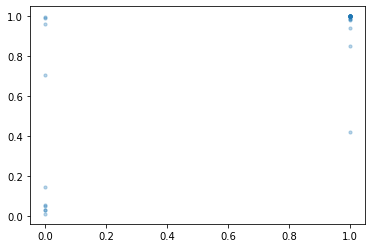

Spearman correlation: 0.6998 (p-value: 0.0000)
Pearson correlation: 0.7595 (p-value: 0.0000)


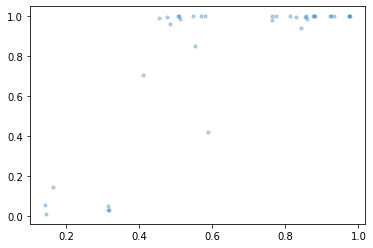

In [5]:
fields = ["color", "label", "concrete_scale"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (
        ("color", x["attributes"]["color"]),
        ("label", x["attributes"]["label"]),
        # ("position", x["attributes"]["position"]),
        ("concrete_scale", x["attributes"]["concrete_scale"]),
    )
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [text_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)
compute_correlation(
    [text_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)

## Image Correlation Analysis

Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.28it/s]


[((('color', 'green'), ('label', 1), ('concrete_scale', 1)), 0.0),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 2)), 0.0),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 0)), 0.05)]

[((('color', 'green'), ('label', 1), ('concrete_scale', 1)),
  0.2650293752551079),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 2)),
  0.2865790318697691),
 ((('color', 'green'), ('label', 1), ('concrete_scale', 0)),
  0.3257053758949041)]

Spearman correlation: 0.3860 (p-value: 0.0201)
Pearson correlation: 0.5381 (p-value: 0.0007)


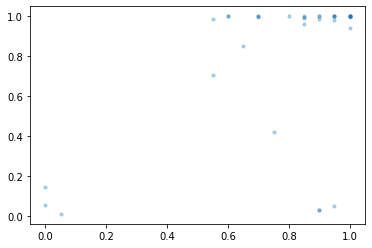

Spearman correlation: 0.4557 (p-value: 0.0052)
Pearson correlation: 0.5309 (p-value: 0.0009)


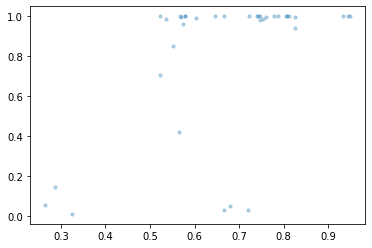

In [19]:
fields = ["color", "label", "concrete_scale"]


image_generated_data = [
    json.loads(line) for line in open("color/color_text_data_generated_images.jsonl")
]

for i, item in enumerate(image_generated_data):
    item["image"] = item["image"].replace("19.png", f"{i % 20}.png")  # bug fix
    item["image"] = item["image"].replace("..", "")
    item["label"] = {"square": 0, "triangle": 1}[item["attributes"]["shape"]]
    item["attributes"]["label"] = item["label"]
    item["attributes"]["concrete_scale"] = {"small": 0, "medium": 1, "large": 2}[
        item["attributes"]["size"]
    ]


image_generated_dataset = ImageDataset(data=image_generated_data)
image_generated_dataloader = create_dataloader(
    dataset=image_generated_dataset, modality="image", transform=transform
)
image_generated_metrics = run_one_epoch(
    dataloader=image_generated_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
image_generated_preds, image_generated_labels = (
    image_generated_metrics["preds"],
    image_generated_metrics["labels"],
)
image_generated_subgroups = subgrouping(image_generated_data, fields)
image_generated_subgroup_metrics = computing_subgroup_metrics(
    image_generated_preds, image_generated_labels, image_generated_subgroups
)
pprint(sorted(image_generated_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

image_generated_logits = image_generated_metrics["logits"]
image_generated_probs = (
    torch.softmax(torch.tensor(image_generated_logits), dim=1).numpy().tolist()
)
image_generated_subgroup_probs = defaultdict(list)
for i, x in enumerate(image_generated_data):
    key = (
        ("color", x["attributes"]["color"]),
        ("label", x["attributes"]["label"]),
        # ("position", x["attributes"]["position"]),
        ("concrete_scale", x["attributes"]["concrete_scale"]),
    )
    value = image_generated_probs[i][x["label"]]
    image_generated_subgroup_probs[key].append(value)
image_generated_subgroup_probs = {
    # k: v[-1] for k, v in image_generated_subgroup_probs.items()
    k: float(np.mean(v))
    for k, v in image_generated_subgroup_probs.items()  # 1 image correlation
}
pprint(sorted(image_generated_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [image_generated_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Accuracy-Accuracy Correlation
compute_correlation(
    [image_generated_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Prob-Accuracy Correlation

# Attribute-based Interpretation

In [98]:
attributes = {
    "scale": {"small", "medium", "large"},
    "color": {"blue", "cyan", "green", "orange", "pink", "red"},
}

## Direct influence

In [99]:
attribute_list = list(attributes["color"])

attribute_embeddings = F.normalize(
    clip_model.encode_text(clip.tokenize(attribute_list).cuda())
)
probs = torch.softmax(model(attribute_embeddings), dim=1)

attribute_scores = {
    attribute_list[i]: float(probs[i, 1]) for i in range(len(attribute_list))
}

print("If we care about triangle (label = 1), the most similar attributes are:")
print(sorted(attribute_scores.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about triangle (label = 1), the most similar attributes are:
[('orange', 0.8680298924446106), ('red', 0.4075278043746948), ('pink', 0.3324088752269745), ('cyan', 0.32082444429397583), ('blue', 0.2729652225971222), ('green', 0.06301457434892654)]


## Aggregated Influence: Shapley Value s(a) = E_{S subset {F \ a}} [f(S, a) - f(S)]

In [100]:
scale_list = list(attributes["scale"])
color_list = list(attributes["color"])

attribute_shapley = {}
print(
    "If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):"
)
for scale in scale_list:
    prompts = (
        [f"a {color} square." for color in color_list]
        + [f"a {color} triangle." for color in color_list]
        + [f"a {scale} {color} square." for color in color_list]
        + [f"a {scale} {color} triangle." for color in color_list]
    )
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(color_list) * 2 :, 1] - probs[: 2 * len(color_list), 1]).mean()
    attribute_shapley[scale] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):
[('large', tensor(-0.0081)),
 ('small', tensor(-0.0188)),
 ('medium', tensor(-0.0250))]


In [102]:
scale_list = list(attributes["scale"])
color_list = list(attributes["color"])

attribute_shapley = {}
print(
    "If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):"
)
for color in color_list:
    prompts = (
        [f"a {scale} square." for scale in scale_list]
        + [f"a {scale} triangle." for scale in scale_list]
        + [f"a {scale} {color} square." for scale in scale_list]
        + [f"a {scale} {color} triangle." for scale in scale_list]
    )
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(scale_list) * 2 :, 1] - probs[: 2 * len(scale_list), 1]).mean()
    attribute_shapley[color] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):
[('orange', tensor(0.3736)),
 ('red', tensor(-0.0470)),
 ('blue', tensor(-0.0784)),
 ('cyan', tensor(-0.0979)),
 ('pink', tensor(-0.1181)),
 ('green', tensor(-0.3321))]
